In [2]:
from __future__ import division, print_function
import os
import sys

import numpy as np
from gwbench import basic_relations as br


In [3]:
bilby_path = '../bilby_3g'
if os.path.isdir(bilby_path):
  import sys
  sys.path.append(bilby_path)
  print('Added path: ', bilby_path)

import bilby

import bilby.gw.utils as gwutils


Added path:  ../bilby_3g


In [4]:
m1src = 520.0
m2src= 100.0
theta_jn_deg=0.0
ra_deg=60.0
dec_deg=60.0
psi_deg=60.0
redshift=0.2
duration=np.round(4*br.f_isco_Msolar(m1src+m2src))
fsample=2048.0
fmin=20.
fref=20.
waveform='IMRPhenomXAS'
waveform_det='IMRPhenomD'
outdir='./PE_tests/equalMass_IMRPhenomD'
margPhase = False
seed = 1290643798
# ifo_list= ['CE', 'CES', 'ET1', 'ET2', 'ET3']
ifo_list= ['CE']



In [5]:
# Set the duration and sampling frequency of the data segment that we're
# going to inject the signal into
sampling_frequency = fsample
sampler = 'dynesty'
# Specify the output directory and the name of the simulation.

# Set up a random seed for result reproducibility.  This is optional!
np.random.seed(seed)


In [6]:
# We are going to inject a binary black hole waveform.  We first establish a
# dictionary of parameters that includes all of the different waveform
# parameters, including masses of the two black holes (mass_1, mass_2),
# spins of both black holes (a, tilt, phi), etc.
bilby.gw.cosmology._set_default_cosmology()
cosmo = bilby.gw.cosmology.DEFAULT_COSMOLOGY
mtotal = m1src+m2src
q=m2src/m1src
# print(q)
tilt_1=0.
tilt_2=0.
chi_1=0.
chi_2=0.
phi_12=0.
phi_jl=0.
z=redshift
dL=cosmo.luminosity_distance(z).value
theta_jn_rad = theta_jn_deg*np.pi/180.0
ra_rad = ra_deg*np.pi/180.0
dec_rad = dec_deg*np.pi/180.0
psi_rad = psi_deg*np.pi/180.0
phase=0.0
gps_time=1577491218.0
m1_det = m1src*(1+z)
m2_det = m2src*(1+z)
Mc_det = bilby.gw.conversion.component_masses_to_chirp_mass(m1_det, m2_det)
total_mass_det = m1_det+m2_det
approx = waveform
approx_det = waveform_det
label = 'mtotal%.1f_q%.1f_z%.1f_iota%.1f_%s' %(mtotal, 1./q, redshift, theta_jn_deg, approx)
bilby.core.utils.setup_logger(outdir=outdir, label=label)
fref=fref
fmin=fmin


In [7]:
# injection/simulation of a waveform
injection_parameters = dict(
	chirp_mass = Mc_det, mass_1=m1_det, mass_2=m2_det, chi_1=chi_1, chi_2=chi_2, #tilt_1=tilt_1, tilt_2=tilt_2,
	#phi_12=phi_12, phi_jl=phi_jl, 
	luminosity_distance=dL, theta_jn=theta_jn_rad, psi=psi_rad,
	phase=phase, geocent_time=gps_time, ra=ra_rad, dec=dec_rad, reference_frequency=fref, minimum_frequency=fmin)


In [8]:
# Fixed arguments passed into the source model
# approx: IMRPhenomPv2: standard, (2,2), IMRPhenomXPHM (l,m)=(2,2),...(4,4)
waveform_arguments = dict(waveform_approximant=approx, reference_frequency=fref, minimum_frequency=fmin)

In [9]:
waveform_generator = bilby.gw.WaveformGenerator(
	duration=duration, sampling_frequency=sampling_frequency,
	frequency_domain_source_model=bilby.gw.source.lal_binary_black_hole,
	parameter_conversion=bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters,
	waveform_arguments=waveform_arguments,start_time=injection_parameters['geocent_time'] - duration + 2.0)


19:06 bilby INFO    : Waveform generator initiated with
  frequency_domain_source_model: bilby.gw.source.lal_binary_black_hole
  time_domain_source_model: None
  parameter_conversion: bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters


In [10]:
deltaT = gwutils.calculate_time_to_merger(
            frequency=1,
            mass_1=m1_det,
            mass_2=m2_det,
        )

deltaT = np.round(deltaT, 1)
deltaT


78.5

# Set detection waveform model

In [11]:
# Set detection waveform model
waveform_arguments = dict(waveform_approximant=approx_det, reference_frequency=fref, minimum_frequency=fmin)

In [12]:
waveform_generator = bilby.gw.WaveformGenerator(
	duration=duration, sampling_frequency=sampling_frequency,
	frequency_domain_source_model=bilby.gw.source.lal_binary_black_hole,
	parameter_conversion=bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters,
	waveform_arguments=waveform_arguments,start_time=injection_parameters['geocent_time'] - duration + 2.0)

19:06 bilby INFO    : Waveform generator initiated with
  frequency_domain_source_model: bilby.gw.source.lal_binary_black_hole
  time_domain_source_model: None
  parameter_conversion: bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters


In [13]:
# Set up interferometers.
ifos = bilby.gw.detector.InterferometerList(ifo_list)
for ifo in ifos:
	#ifo.set_strain_data_from_power_spectral_density(
	ifo.set_strain_data_from_zero_noise(
		sampling_frequency=sampling_frequency, duration=duration,
		start_time=injection_parameters['geocent_time'] - duration + 2.0)
	ifo.inject_signal_from_waveform_generator(parameters=injection_parameters, waveform_generator=waveform_generator)
	# ifo.inject_signal(waveform_generator=waveform_generator, parameters=injection_parameters)



19:06 bilby INFO    : Injected signal in CE:
19:06 bilby INFO    :   optimal SNR = 807.47
19:06 bilby INFO    :   matched filter SNR = 807.47+0.00j
19:06 bilby INFO    :   chirp_mass = 224.0293476850534
19:06 bilby INFO    :   mass_1 = 624.0
19:06 bilby INFO    :   mass_2 = 120.0
19:06 bilby INFO    :   chi_1 = 0.0
19:06 bilby INFO    :   chi_2 = 0.0
19:06 bilby INFO    :   luminosity_distance = 1011.4196559461382
19:06 bilby INFO    :   theta_jn = 0.0
19:06 bilby INFO    :   psi = 1.0471975511965976
19:06 bilby INFO    :   phase = 0.0
19:06 bilby INFO    :   geocent_time = 1577491218.0
19:06 bilby INFO    :   ra = 1.0471975511965976
19:06 bilby INFO    :   dec = 1.0471975511965976
19:06 bilby INFO    :   reference_frequency = 20.0
19:06 bilby INFO    :   minimum_frequency = 20.0


In [14]:
# For this analysis, we implemenet the standard BBH priors defined, except for
# the definition of the time prior, which is defined as uniform about the
# injected value.
# Furthermore, we decide to sample in total mass and mass ratio, due to the
# preferred shape for the associated posterior distributions.
q_min=0.1
q_max=1.0
total_mass_min = total_mass_det*(0.25)
total_mass_max = total_mass_det*(2.5)
if approx=="IMRPhenomXPHM":
	if q>=0.8:
		chirp_mass_min = Mc_det*(0.75)
		chirp_mass_max = Mc_det*(1.25)
		total_mass_min = total_mass_det*(0.75)
		total_mass_max = total_mass_det*(1.25)
	if (q>=0.4)*(q<0.8):
		chirp_mass_min = Mc_det*(0.75)
		chirp_mass_max = Mc_det*(1.5)
		total_mass_min = total_mass_det*(0.75)
		total_mass_max = total_mass_det*(1.5)
	if q<0.4:
		chirp_mass_min = Mc_det*(0.5)
		chirp_mass_max = Mc_det*(2.0)
		total_mass_min = total_mass_det*(0.5)
		total_mass_max = total_mass_det*(2.0)
dist_min = dL/10.0
dist_max = dL*5.0
# We first output the prior ranges in a text file as a record tracker
BBHprior = \
"""mass_ratio = PowerLaw(name='mass_ratio', minimum=%f, maximum=%f, alpha=-2.0)
total_mass = Uniform(name='total_mass', minimum=%f, maximum=%f)
luminosity_distance = bilby.gw.prior.UniformSourceFrame(name='luminosity_distance', minimum=%f, maximum=%f)
dec = Cosine(name='dec')
ra = Uniform(name='ra', minimum=0, maximum=2 * np.pi, boundary='periodic')
theta_jn = Sine(name='theta_jn')
psi = Uniform(name='psi', minimum=0, maximum=np.pi, boundary='periodic')
delta_phase = Uniform(name='delta_phase', minimum=0, maximum=2 * np.pi, boundary='periodic')
chi_1 = Uniform(name='chi_1', minimum=0, maximum=0.99)
chi_2 = Uniform(name='chi_2', minimum=0, maximum=0.99)
geocent_time = Uniform(name='geocent_time', minimum=%f, maximum=%f)
""" %(q_min, q_max, total_mass_min, total_mass_max, dist_min, dist_max, gps_time-0.1, gps_time+0.1)

with open(outdir+'/%s.prior' %label,'w') as f_prior:
	f_prior.write(BBHprior)

priors = bilby.gw.prior.BBHPriorDict(outdir+'/%s.prior' %label)


In [15]:
# Initialise the likelihood by passing in the interferometer data (ifos) and
# the waveform generator, as well the priors.
# The explicit time, distance, and phase marginalizations are turned on to
# improve convergence, and the parameters are recovered by the conversion
# function.
likelihood = bilby.gw.GravitationalWaveTransient(
	interferometers=ifos, waveform_generator=waveform_generator, priors=priors,
	distance_marginalization=True, phase_marginalization=margPhase, time_marginalization=True, distance_marginalization_lookup_table=outdir+'/%s_dist_lookup.npz' %label)


19:06 bilby INFO    : Loaded distance marginalisation lookup table from ./PE_tests/equalMass_IMRPhenomD/mtotal620.0_q5.2_z0.2_iota0.0_IMRPhenomXAS_dist_lookup.npz.


In [ ]:
# Run sampler. In this case we're going to use the `dynesty` sampler
# The conversion function will determine the distance, phase and coalescence
# time posteriors in post processing.
result = bilby.run_sampler(
	likelihood=likelihood, priors=priors, sampler=sampler, nlive=60, nact=4, maxmcmc=500, npool=4,
	injection_parameters=injection_parameters, outdir=outdir,
	label=label,
	conversion_function=bilby.gw.conversion.generate_all_bbh_parameters)



19:06 bilby INFO    : Running for label 'mtotal620.0_q5.2_z0.2_iota0.0_IMRPhenomXAS', output will be saved to './PE_tests/equalMass_IMRPhenomD'
19:06 bilby INFO    : Using lal version 7.1.3
19:06 bilby INFO    : Using lal git version Branch: None;Tag: lal-v7.1.3;Id: fa9914e5d72cc6168463b5fce79eeba8037404ad;;Builder: Adam Mercer <adam.mercer@ligo.org>;Repository status: CLEAN: All modifications committed
19:06 bilby INFO    : Using lalsimulation version 3.0.0
19:06 bilby INFO    : Using lalsimulation git version Branch: None;Tag: lalsimulation-v3.0.0;Id: e8e5ff5aa1ae2676019f59b6785f55284c417fda;;Builder: Adam Mercer <adam.mercer@ligo.org>;Repository status: CLEAN: All modifications committed
19:06 bilby INFO    : Search parameters:
19:06 bilby INFO    :   mass_ratio = PowerLaw(alpha=-2.0, minimum=0.1, maximum=1.0, name='mass_ratio', latex_label='$q$', unit=None, boundary=None)
19:06 bilby INFO    :   total_mass = Uniform(minimum=186.0, maximum=1860.0, name='total_mass', latex_label='$M$

test 1


19:07 bilby INFO    : Single likelihood evaluation took 3.326e-02 s


0it [00:00, ?it/s]

19:07 bilby INFO    : Using sampler Dynesty with kwargs {'bound': 'multi', 'sample': 'rwalk', 'verbose': True, 'periodic': None, 'reflective': None, 'check_point_delta_t': 1800, 'nlive': 60, 'first_update': None, 'walks': 100, 'npdim': None, 'rstate': None, 'queue_size': 4, 'pool': None, 'use_pool': None, 'live_points': None, 'logl_args': None, 'logl_kwargs': None, 'ptform_args': None, 'ptform_kwargs': None, 'enlarge': 1.5, 'bootstrap': None, 'vol_dec': 0.5, 'vol_check': 8.0, 'facc': 0.2, 'slices': 5, 'update_interval': 36, 'print_func': <bound method Dynesty._print_func of <bilby.core.sampler.dynesty.Dynesty object at 0x7fa64ac31750>>, 'dlogz': 0.1, 'maxiter': None, 'maxcall': None, 'logl_max': inf, 'add_live': True, 'print_progress': True, 'save_bounds': False, 'n_effective': None, 'maxmcmc': 500, 'nact': 4, 'print_method': 'tqdm'}
19:07 bilby INFO    : Checkpoint every check_point_delta_t = 600s
19:07 bilby INFO    : Using dynesty version 1.0.1
19:07 bilby INFO    : Using the bilby-

230it [00:23,  2.35it/s, bound:0 nc:121 ncall:2.4e+03 eff:9.7% logz-ratio=315619.99+/-0.53 dlogz:10617.345>0.1]  

19:07 bilby INFO    : Run interrupted by signal 2: checkpoint and exit on 130
19:07 bilby INFO    : Written checkpoint file ./PE_tests/equalMass_IMRPhenomD/mtotal620.0_q5.2_z0.2_iota0.0_IMRPhenomXAS_resume.pickle
19:07 bilby INFO    : Starting to close worker pool.


: 

: 

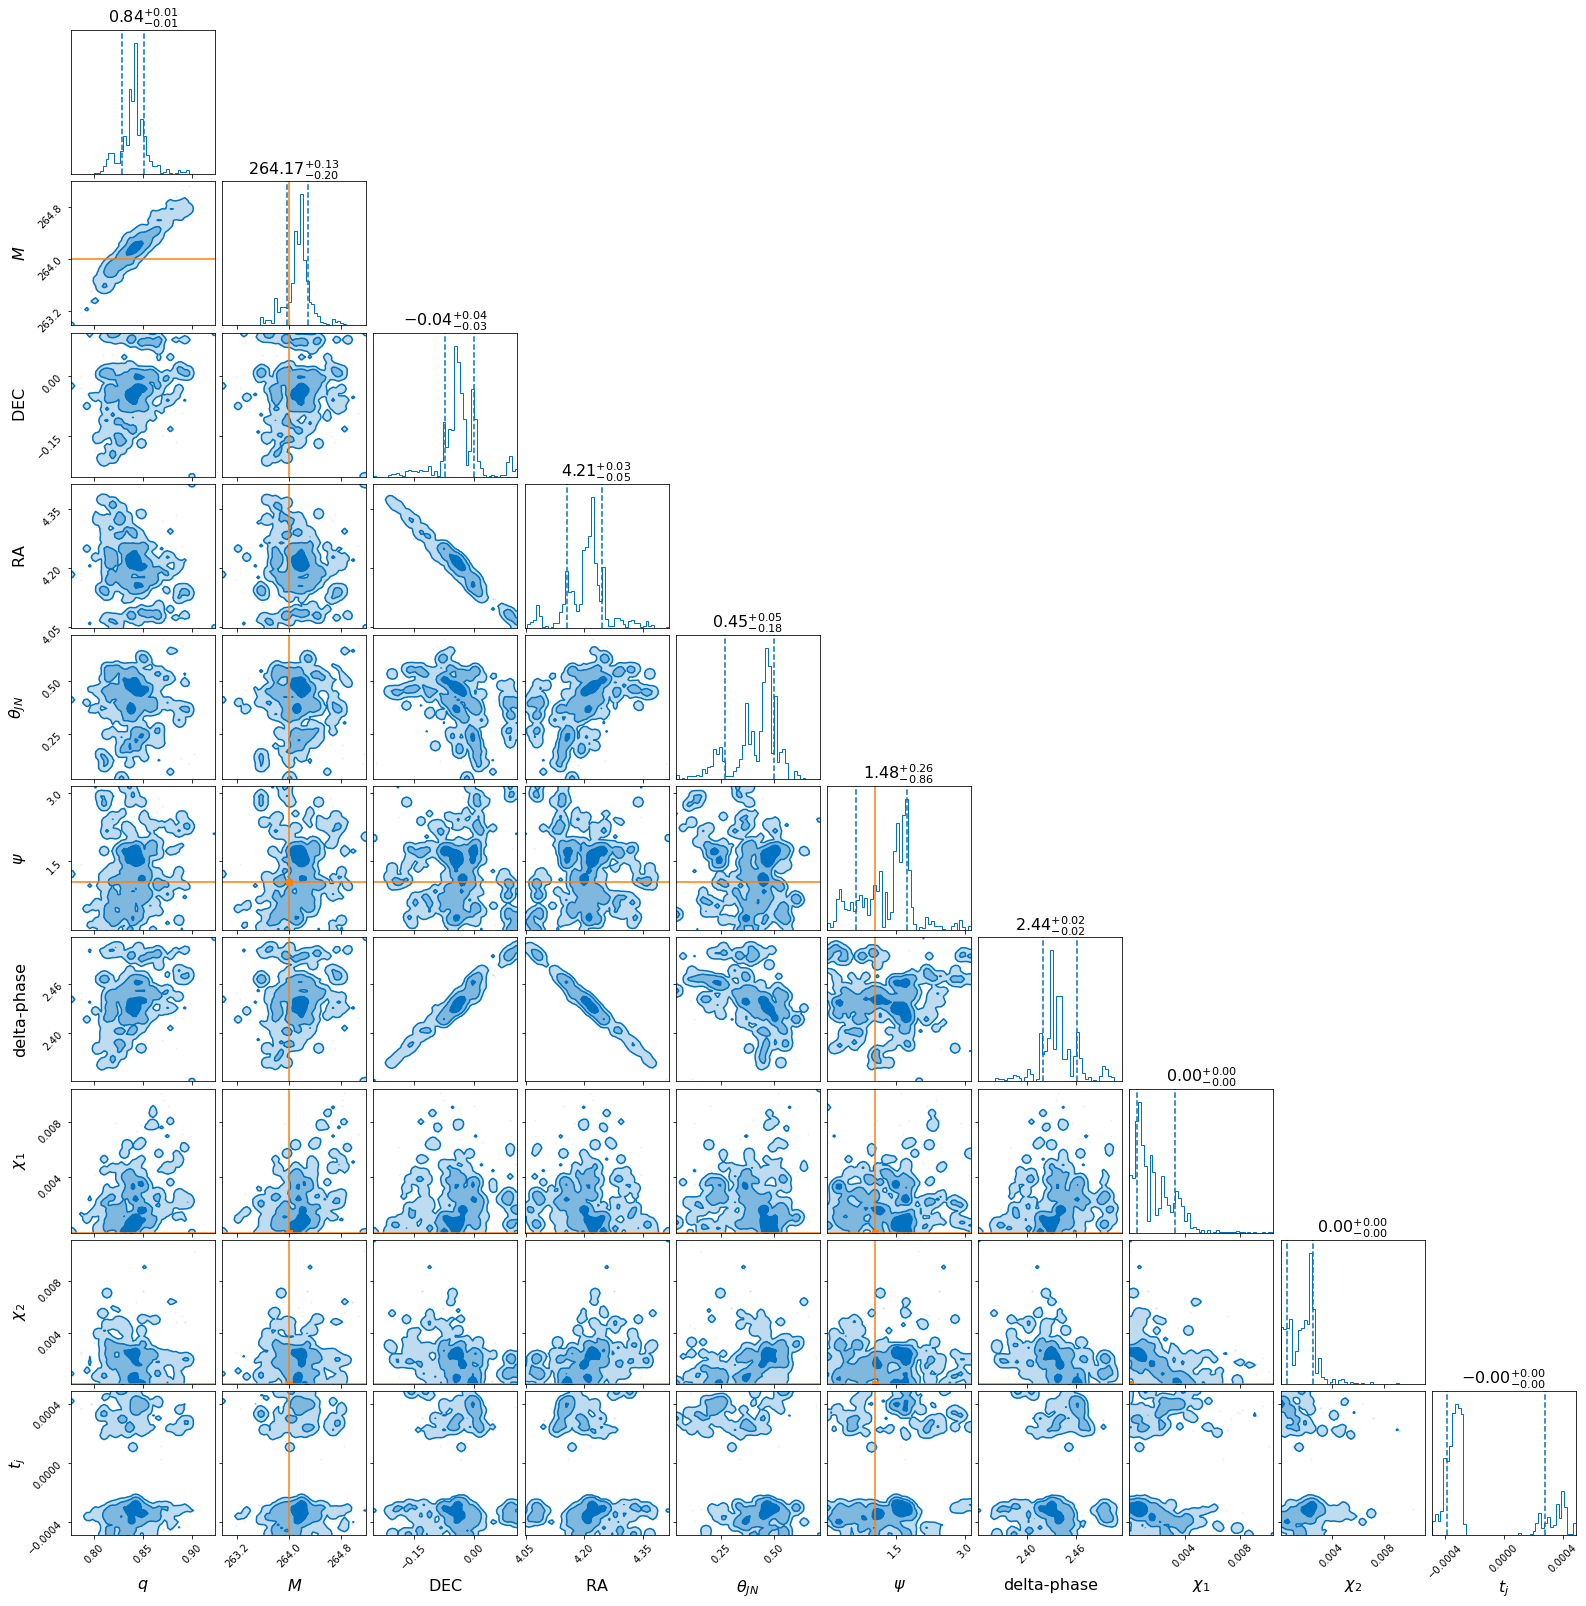

In [23]:
# Make a corner plot.
result.plot_corner()
